In [678]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns
plt.rcParams['font.size'] = 20

!pip install pyswarm
from pyswarm import pso

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [679]:
# Load the Volvo open source drilling data

data = pd.read_csv("volvo.csv")

In [680]:
data.head()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
0,3305,26217.864,1.314720,0.004088,0.086711,0.071719,1.0,0.001
1,3310,83492.293,1.328674,0.005159,0.095208,0.116548,1.0,0.001
2,3315,97087.882,1.420116,0.005971,0.061636,0.104283,1.0,0.001
3,3320,54793.206,1.593931,0.005419,0.043498,0.110040,1.0,0.001
4,3325,50301.579,1.653262,0.005435,0.035252,0.120808,1.0,0.001


In [681]:
data.shape

(151, 8)

In [682]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Depth     151 non-null    int64  
 1   WOB       151 non-null    float64
 2   SURF_RPM  151 non-null    float64
 3   ROP_AVG   151 non-null    float64
 4   PHIF      151 non-null    float64
 5   VSH       151 non-null    float64
 6   SW        151 non-null    float64
 7   KLOGH     151 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 9.6 KB


In [683]:
data.describe()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,3697.417219,45393.934391,2.034981,0.007800,0.084423,0.299809,0.975579,37.072228
std,227.169433,15784.246882,0.208492,0.001476,0.068230,0.264596,0.108946,127.186210
min,3305.000000,16961.916000,1.314720,0.002666,0.002968,0.049451,0.351393,-0.001124
25%,3502.500000,34320.946500,1.998711,0.007368,0.037550,0.108539,1.000000,0.001000
50%,3700.000000,44243.480000,1.999697,0.008157,0.059274,0.193100,1.000000,0.001000
75%,3887.500000,53212.685000,2.001069,0.008760,0.097212,0.387664,1.000000,0.001000
max,4085.000000,97087.882000,2.639233,0.010447,0.279346,1.000000,1.013335,709.158935


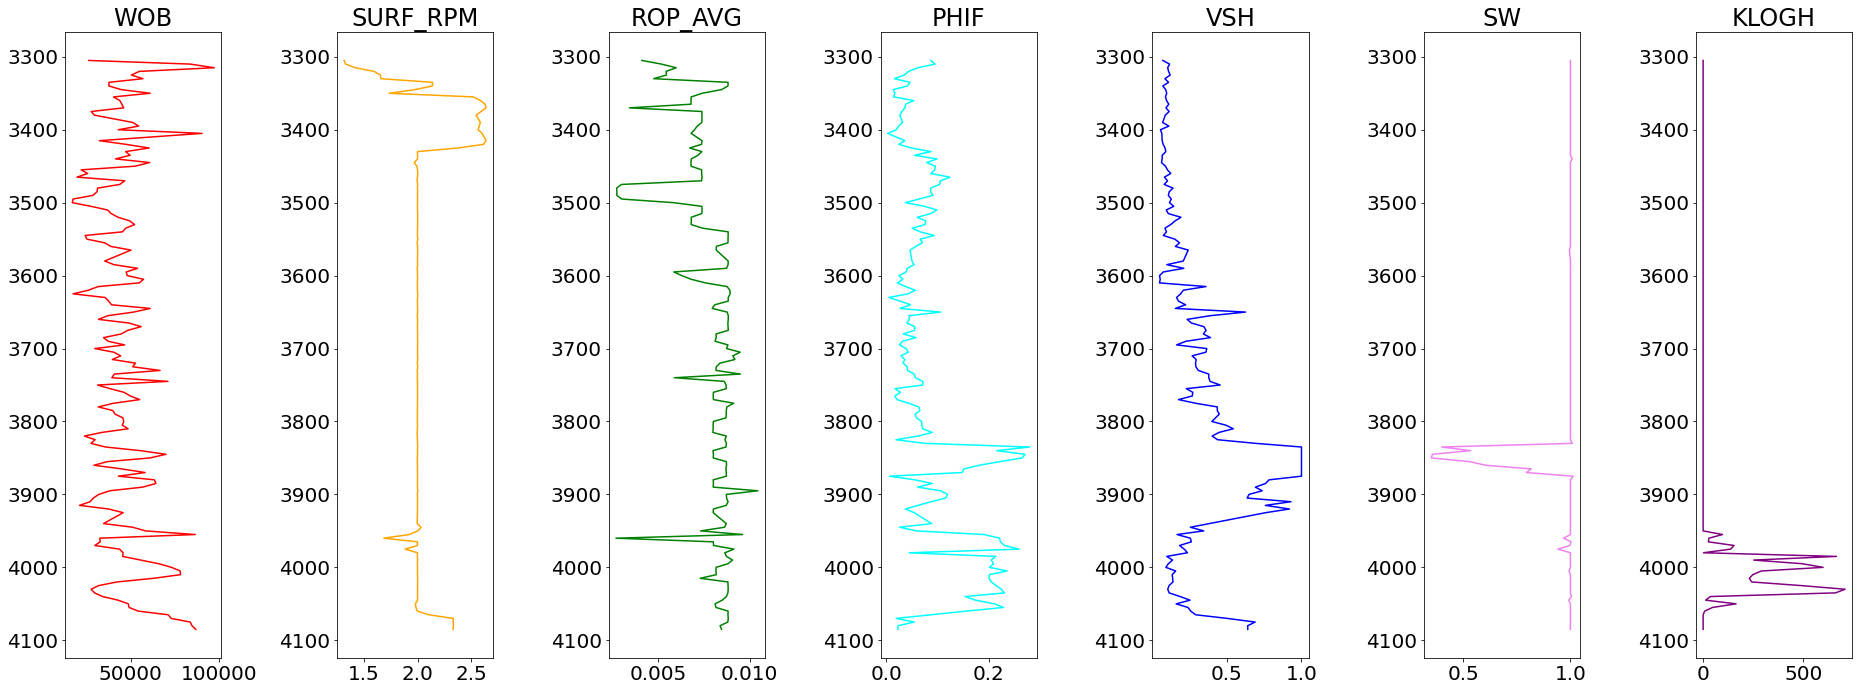

In [684]:
# Visualising data through logs

logs = data.columns[1:]
colors = ['red', 'orange', 'green', 'cyan', 'blue', 'violet', 'purple']

plt.figure(figsize=(30,10))
for i in range(len(logs)):
    plt.subplot(1,8,i+1)
    plt.plot(data[logs[i]],data.Depth, color=colors[i])
    plt.title(logs[i])
    plt.gca().invert_yaxis()
    
plt.tight_layout()

In [685]:
corr = data.corr()

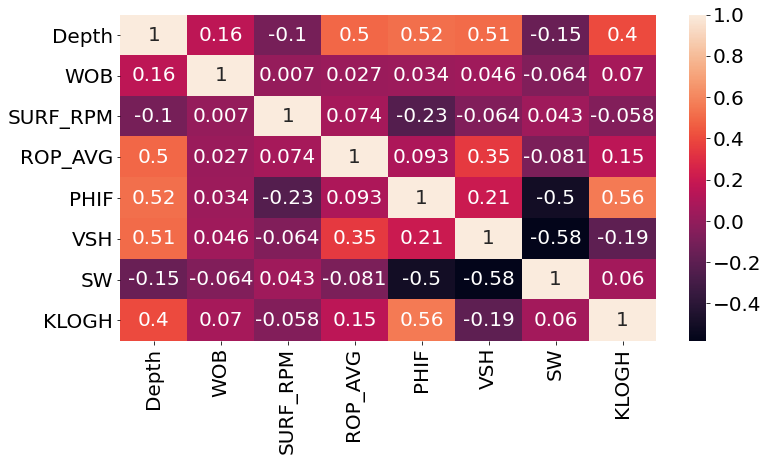

In [686]:
# visualizing correlation between the data through heatmap
import seaborn as sns

plt.figure(figsize = (12,6))
sns.heatmap(corr, annot = True)
plt.show()

In [687]:
# looking for Multicollinearity
hetro = data
hetro = (hetro-hetro.min())/(hetro.max()- hetro.min())
hetro.var().sort_values(ascending = False)

Depth       0.084822
VSH         0.077485
PHIF        0.060947
WOB         0.038806
ROP_AVG     0.035991
KLOGH       0.032166
SW          0.027088
SURF_RPM    0.024778
dtype: float64

### Gradient Boosting Machine for ROP prediction

In [688]:
# Separate feature and target, where X is predictor & y is the response
X = data.drop(['ROP_AVG'], axis=1)
y = data['ROP_AVG']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=10)

# Make pipeline
steps = [('scaler', StandardScaler()), 
         ('gbr', GradientBoostingRegressor(min_samples_leaf=6, max_depth=20, 
                                           random_state=10))]
pipe = Pipeline(steps)

# Fit pipeline to training data
pipe.fit(X_train,y_train)

# Evaluate model with R2 metric
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print(f'R2 on train set: {train_score:.2f}')
print(f'R2 on test set: {test_score:.2f}')

R2 on train set: 0.98
R2 on test set: 0.77


In [689]:
# calculating Root Mean Squared Error to check the accuracy of our model
model = GradientBoostingRegressor()
model.fit(X,y)
prediction = model.predict(X)
mse = mean_squared_error(prediction,y)
rmse = np.sqrt(mse)
rmse
print(f'root mean squared error:,{rmse:.7f}')

root mean squared error:,0.0002086


### Assessing Models With K-fold Cross-Validation and Validation Curves

In [690]:
k = 10
training = k-1
test = 1

data.shape
indx = int(151*.80)
train = data[:indx]
test = data[indx:]

In [691]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)
model= GradientBoostingRegressor()

rmses = []

for train_index, test_index in kf.split(data):
    
    #print(train_index, test_index)
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    model.fit(X, y)
    prediction = model.predict(X)
    mse = mean_squared_error(prediction, y)
    rmse = np.sqrt(mse)
    rmses.append(rmse)

In [692]:
rmses = [round(rmses,7) for rmses in rmses]
print(rmses)

[0.0002086, 0.0002086, 0.0002086, 0.0002086, 0.0002086, 0.0002086, 0.0002086, 0.0002086, 0.0002086, 0.0002086]


In [693]:
np.mean(rmses)

0.00020860000000000003

In [694]:
def predict(model, Depth, PHIF, VSH, SW, KLOGH, WOB, SURF_RPM):
    # Make a test input
    X_test = np.array([Depth, PHIF, VSH, SW, KLOGH, WOB, SURF_RPM])
    X_test = X_test.reshape(1,-1)
    
    # Predict on a test input
    y_pred = model.predict(X_test)
    return y_pred[0]

In [695]:
# Predict on new inputs
predict(pipe, 4000, 0.2, 0.5, 1, 500, WOB=5e4, SURF_RPM=2) 

0.0050679161835807136

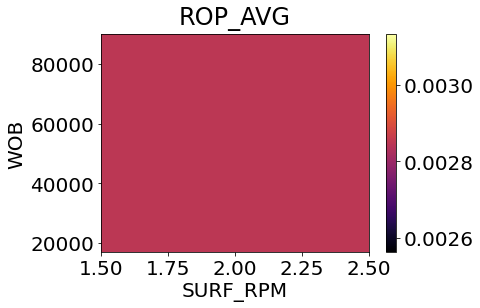

In [675]:
def plot_space(model, WOB, SURF_RPM, constant_inputs):
  N_matrix = np.empty((len(WOB), len(SURF_RPM)))
  for i in range(len(WOB)):
    for j in range(len(SURF_RPM)):
      # Unwrap constant variables
      Depth, PHIF, VSH, SW, KLOGH = constant_inputs.values()
      N = predict(model, Depth, PHIF, VSH, SW, KLOGH, WOB=WOB[i], SURF_RPM=SURF_RPM[j])
      N_matrix[i][j] = N  
    
  plt.imshow(N_matrix, origin='lower', aspect='auto', cmap='inferno',
             extent=(min(SURF_RPM), max(SURF_RPM), min(WOB), max(WOB)))  
  plt.xlabel('SURF_RPM')
  plt.ylabel('WOB')
  plt.title('ROP_AVG', pad=10)    
  plt.colorbar()

# Range of WOB and RPM values
WOB = np.linspace(17e3, 90e3, 30)
SURF_RPM = np.linspace(1.5, 2.5, 30)

# Constant input variables
constant_inputs = {'Depth': 3480, 'PHIF': 0.09, 'VSH': 0.1, 
                   'SW': 1, 'KLOGH': 0.001}                   

# Plot prediction space
plot_space(pipe, WOB, SURF_RPM, constant_inputs)

In [676]:
# Data at depth 3480 m
data[data.Depth==3480]

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
33,3480,31236.811,1.999362,0.00271,0.086571,0.139695,1.0,0.001


In [677]:
# Define objective function. "pipe" as model
def f(X):
  return -pipe.predict(X.reshape(1,-1)) # Minus sign to optimize

# Lower bounds of feature variables in the order of X.columns
lb = np.array([3480, 2e4, 1.5, 0.09, 0.1, 1, 0.001])

# Upper bounds of feature variables in the order of X.columns
ub = np.array([3480, 9e4, 2.5, 0.09, 0.1, 1, 0.001])
ub += 1e-10

# Solve optimization
xopt, fopt = pso(f, lb, ub, swarmsize=200, omega=0.3, phip=.5, 
                 phig=0.7, maxiter=1000, minstep=1e-8)

# Print values that causes maximum ROP from xopt
for i in range(len(X.columns)):
  print(f'{X.columns[i]}: {xopt[i]:.2f}')

# Print value of maximum ROP from popt
print(f'Maximum ROP achieved: {-fopt}')

Stopping search: maximum iterations reached --> 1000
Depth: 3480.00
WOB: 63106.45
SURF_RPM: 2.00
PHIF: 0.09
VSH: 0.10
SW: 1.00
KLOGH: 0.00
Maximum ROP achieved: [0.00567214]
